In [106]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tqdm import tqdm
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.model_selection import train_test_split
import os, multiprocessing


In [107]:
mem_bytes = os.sysconf('SC_PAGE_SIZE') * os.sysconf('SC_PHYS_PAGES')
mem_gib = mem_bytes / (1024.**3)
print("Computer characteristics: ")
print("RAM: %f GB" % mem_gib)
print("CORES: %d" % multiprocessing.cpu_count())


Computer characteristics: 
RAM: 7.653069 GB
CORES: 4


In [243]:
train = pd.read_csv('train.csv')
train.head()

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,2020-01-22,0.0,0.0
1,2,NaN,Afghanistan,2020-01-23,0.0,0.0
2,3,NaN,Afghanistan,2020-01-24,0.0,0.0
3,4,NaN,Afghanistan,2020-01-25,0.0,0.0
4,5,NaN,Afghanistan,2020-01-26,0.0,0.0


In [150]:
print("Null values(train):") 
print(train.isnull().sum())
print("\n")
countries = train['Country_Region'].unique()
print("Number of different countries: ", len(countries))
print("\n")
min_date = train.Date.min()
max_date = train.Date.max()
print("Min date: {0}\nMax date: {1}".format(min_date, max_date))

Null values(train):
Id                    0
Province_State    13376
Country_Region        0
Date                  0
ConfirmedCases        0
Fatalities            0
dtype: int64


Number of different countries:  180


Min date: 2020-01-22
Max date: 2020-04-06


In [244]:
def fillState(state, country):
    if state == "empty":
        return country
    return state

train['Province_State'].fillna("empty", inplace = True)
train['Province_State'] = train.loc[:,['Province_State', 'Country_Region']].apply(lambda x: fillState(x['Province_State'], x['Country_Region']), axis = 1)


# renaming columns
train=train.rename(columns={'ConfirmedCases':'Confirmed'})

#num_cols=['Confirmed', 'Fatalities']

# cast to int
#for col in num_cols:
#    temp=[int(i) for i in train[col]]
#    train[col]=temp 
    
train.head()

,Id,Province_State,Country_Region,Date,Confirmed,Fatalities
0,1,Afghanistan,Afghanistan,2020-01-22,0.0,0.0
1,2,Afghanistan,Afghanistan,2020-01-23,0.0,0.0
2,3,Afghanistan,Afghanistan,2020-01-24,0.0,0.0
3,4,Afghanistan,Afghanistan,2020-01-25,0.0,0.0
4,5,Afghanistan,Afghanistan,2020-01-26,0.0,0.0


In [152]:
latest = train['Date'].max()
world_confirmed = sum(train[train['Date'] == latest].Confirmed)
print("Number of confirmed cases: ", world_confirmed)
world_fatal = sum(train[train['Date'] == latest].Fatalities)
print("Number of fatal cases: ", world_fatal)

Number of confirmed cases:  1344856.0
Number of fatal cases:  74560.0


In [153]:
latest_data = train[train['Date'] == latest]
latest_data = latest_data.drop(['Province_State'], axis = 1)

confirmed_per_country = latest_data.groupby(['Country_Region']).sum().sort_values(['Confirmed'], ascending = False)
confirmed_per_country = confirmed_per_country.drop(['Id'], axis = 1)
print("First 10 countries by number of confirmed cases:\n")
print(confirmed_per_country[:10])
print("\n")
Serbia = confirmed_per_country.loc["Serbia"]
print("Confirmed cases in Serbia: ", Serbia.Confirmed)
print("Fatal cases in Serbia: ", Serbia.Fatalities)

First 10 countries by number of confirmed cases:

                Confirmed  Fatalities
Country_Region                       
US               366454.0     10779.0
Spain            136675.0     13341.0
Italy            132547.0     16523.0
Germany          103374.0      1810.0
France            98962.0      8926.0
China             82665.0      3335.0
Iran              60500.0      3739.0
United Kingdom    52277.0      5385.0
Turkey            30217.0       649.0
Switzerland       21657.0       765.0


Confirmed cases in Serbia:  2200.0
Fatal cases in Serbia:  58.0


In [154]:
import plotly.graph_objects as go
fig = go.Figure()

Serbia_confirmed = train[train['Country_Region'] == 'Serbia'].groupby(['Date']).sum().Confirmed
# we want to see the progression from the first case in Serbia (for the first 44 days we didn't have any case)
Serbia_confirmed = Serbia_confirmed[44:]
Serbia_fatalities = train[train['Country_Region'] == 'Serbia'].groupby(['Date']).sum().Fatalities
Serbia_fatalities = Serbia_fatalities[44:]
date = train['Date'].unique()
date = date[44:]
fig.add_trace(go.Scatter(x = date, y = Serbia_confirmed, name = "Confirmed cases"))
fig.add_trace(go.Scatter(x = date, y = Serbia_fatalities, name = "Fatal cases"))
fig.update_layout(title = "COVID-19 cases in Serbia",
                 xaxis_title = "Date",
                 yaxis_title = "Cases")


In [245]:
train['Date'] = pd.to_datetime(train['Date'], infer_datetime_format = True)
train_countries = train.groupby("Country_Region")
train_countries.get_group('Serbia').set_index("Date").head()

,Id,Province_State,Country_Region,Confirmed,Fatalities
Date,,,,,
2020-01-22,22364,Serbia,Serbia,0.0,0.0
2020-01-23,22365,Serbia,Serbia,0.0,0.0
2020-01-24,22366,Serbia,Serbia,0.0,0.0
2020-01-25,22367,Serbia,Serbia,0.0,0.0
2020-01-26,22368,Serbia,Serbia,0.0,0.0


In [246]:
Confirmed = pd.pivot_table(train, values = "Confirmed", index = "Date", columns = "Country_Region")
Fatalities = pd.pivot_table(train, values = "Fatalities", index = "Date", columns = "Country_Region")
Confirmed

Country_Region,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,...,Ukraine,United Arab Emirates,United Kingdom,Uruguay,Uzbekistan,Venezuela,Vietnam,West Bank and Gaza,Zambia,Zimbabwe
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
2020-01-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
2020-01-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
2020-01-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-02,273.0,277.0,986.0,428.0,8.0,9.0,1133.0,663.0,639.500,11129.0,...,897.0,1024.0,3417.3,350.0,205.0,146.0,233.0,161.0,39.0,9.0
2020-04-03,281.0,304.0,1171.0,439.0,8.0,15.0,1265.0,736.0,666.250,11524.0,...,1072.0,1264.0,3868.9,369.0,227.0,153.0,237.0,194.0,39.0,9.0
2020-04-04,299.0,333.0,1251.0,466.0,10.0,15.0,1451.0,770.0,693.750,11781.0,...,1225.0,1505.0,4247.6,400.0,266.0,155.0,240.0,217.0,39.0,9.0


### Normalize data

In [247]:
Confirmed = Confirmed.values
Fatalities = Fatalities.values

Confirmed = Confirmed.astype('float32')
Fatalities = Fatalities.astype('float32')

scaler_c = MinMaxScaler(feature_range = (0,1))
scaler_f = MinMaxScaler(feature_range = (0,1))

Confirmed = scaler_c.fit_transform(Confirmed)
Fatalities = scaler_f.fit_transform(Fatalities)


In [248]:
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        if out_end_ix > len(sequences):
            break
            
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
        
    return np.array(X), np.array(y)


In [249]:
n_steps_in, n_steps_out = 2, 1
X_confirmed, y_confirmed = split_sequences(Confirmed, n_steps_in, n_steps_out)
X_fatalities, y_fatalities = split_sequences(Fatalities, n_steps_in, n_steps_out)
print(X_confirmed.shape, y_confirmed.shape)
print(X_fatalities.shape, y_fatalities.shape)


(74, 2, 180) (74, 1, 180)
(74, 2, 180) (74, 1, 180)


### Split the data into train and test sets

We can't use train_test_split function, since observations in our time series dataset are not independent, and this function does a random split

### Confirmed cases

In [250]:
n_c = int(X_confirmed.shape[0]*0.8)

X_train_confirmed = X_confirmed[:n_c]
X_val_confirmed = X_confirmed[n_c:]
y_train_confirmed = y_confirmed[:n_c]
y_val_confirmed = y_confirmed[n_c:]

### Fatal cases

In [252]:
n_f = int(X_fatalities.shape[0]*0.8)

X_train_fatal = X_fatalities[:n_f]
X_val_fatal = X_fatalities[n_f:]
y_train_fatal = y_fatalities[:n_f]
y_val_fatal = y_fatalities[n_f:]

### Model for confirmed cases

In [253]:
n_features = X_confirmed.shape[2]
epochs = 200
batch_size = 32

from keras.layers import RepeatVector, TimeDistributed

model_confirmed = Sequential()
model_confirmed.add(LSTM(50, activation='relu', input_shape =(n_steps_in, n_features)))
#model_confirmed.add(Dropout(0.1))
model_confirmed.add(RepeatVector(n_steps_out))
model_confirmed.add(LSTM(150, activation ='relu', return_sequences = True))
# adding relu to output layer so we don't get negative numbers
model_confirmed.add(TimeDistributed(Dense(n_features, activation = 'relu')))

model_confirmed.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 50)                46200     
_________________________________________________________________
repeat_vector_11 (RepeatVect (None, 1, 50)             0         
_________________________________________________________________
lstm_22 (LSTM)               (None, 1, 150)            120600    
_________________________________________________________________
time_distributed_11 (TimeDis (None, 1, 180)            27180     
Total params: 193,980
Trainable params: 193,980
Non-trainable params: 0
_________________________________________________________________


In [254]:
# msle error penalizes underestimates more than overestimates
# msle only cares about relative difference between true and predicted value

model_confirmed.compile(optimizer='adam', loss = 'msle', metrics = ['acc'])
#callbacks = [ReduceLROnPlateau(monitor='val_l|oss', patience = 5, verbose = 1, factor = 0.6),
 #            EarlyStopping(monitor='val_loss', patience = 20),
  #           ModelCheckpoint(filepath = 'best_model_confirmed.h5', monitor ='val_loss', save_best_only = True)]

# fit the model
hist = model_confirmed.fit(X_train_confirmed, y_train_confirmed, epochs = epochs,  
                    validation_data = (X_val_confirmed, y_val_confirmed), verbose = 0)

In [255]:
scores = model_confirmed.evaluate(X_train_confirmed, y_train_confirmed)
print("Model accuracy: %.2f"%(scores[1]*100),"%")

59/59 [==============================] - 0s 138us/step
Model accuracy: 84.75 %


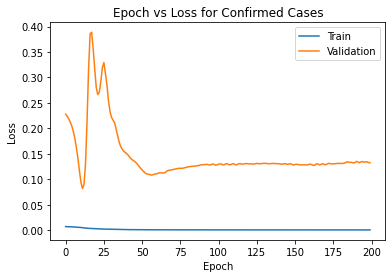

In [256]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Epoch vs Loss for Confirmed Cases')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

### Model for fatal cases

In [257]:
n_features = X_fatalities.shape[2]
epochs = 200
batch_size = 32


model_fatalities = Sequential()
model_fatalities.add(LSTM(50, activation='relu', input_shape =(n_steps_in, n_features)))
model_confirmed.add(Dropout(0.1))
model_fatalities.add(RepeatVector(n_steps_out))
model_fatalities.add(LSTM(150, activation ='relu', return_sequences = True))
model_fatalities.add(TimeDistributed(Dense(n_features, activation = 'relu')))

model_fatalities.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_23 (LSTM)               (None, 50)                46200     
_________________________________________________________________
repeat_vector_12 (RepeatVect (None, 1, 50)             0         
_________________________________________________________________
lstm_24 (LSTM)               (None, 1, 150)            120600    
_________________________________________________________________
time_distributed_12 (TimeDis (None, 1, 180)            27180     
Total params: 193,980
Trainable params: 193,980
Non-trainable params: 0
_________________________________________________________________


In [258]:

model_fatalities.compile(optimizer='adam', loss = 'msle', metrics = ['acc'])
#callbacks = [ReduceLROnPlateau(monitor='val_l|oss', patience = 5, verbose = 1, factor = 0.6),
 #            EarlyStopping(monitor='val_loss', patience = 20),
  #           ModelCheckpoint(filepath = 'best_model_confirmed.h5', monitor ='val_loss', save_best_only = True)]

# fit the model
hist = model_fatalities.fit(X_train_fatal, y_train_fatal, epochs = epochs,  
                    validation_data = (X_val_fatal, y_val_fatal), verbose = 0)

In [259]:
scores = model_fatalities.evaluate(X_train_fatal, y_train_fatal)
print("Model accuracy: %.2f"%(scores[1]*100),"%")

59/59 [==============================] - 0s 173us/step
Model accuracy: 94.92 %


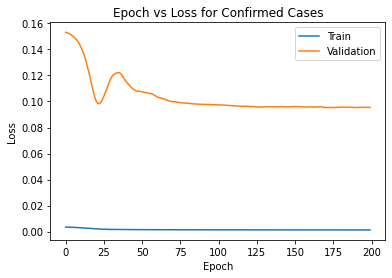

In [260]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Epoch vs Loss for Confirmed Cases')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

In [57]:
#last_confirmed = list()
#last_confirmed.append(Confirmed[len(Confirmed)-n_steps_in:len(Confirmed)+1])
#last_confirmed = np.array(last_confirmed)
#print(last_confirmed.shape)


(1, 2, 180)


In [261]:
#trainPredict = model_confirmed.predict(X_train_confirmed)
testPredict = model_confirmed.predict(X_val_confirmed)

print(testPredict.shape)

nsamples, nx, ny = testPredict.shape
d2_testPredict = testPredict.reshape((nsamples,nx*ny))
d2_testPredict = scaler_c.inverse_transform(d2_testPredict)

nsamples, nx, ny = y_val_confirmed.shape
d2_y_val_confirmed = y_val_confirmed.reshape((nsamples,nx*ny))
d2_y_val_confirmed = scaler_c.inverse_transform(d2_y_val_confirmed)

print(d2_testPredict.shape)

#print("Number of confirmed cases for tomorrow: ", d2_testPredict[-1])


(15, 1, 180)
(15, 180)


In [264]:
import datetime
from dateutil.relativedelta import relativedelta

res_ = dict()   
countries = train['Country_Region'].unique()
#len(countries)
dates = []
start_date = "2020-3-23"
date1 = datetime.datetime.strptime(start_date, "%Y-%m-%d")
for i in range(len(d2_testPredict)):
    res_[i] = d2_testPredict[i]
    dates.append(date1.strftime("%Y-%m-%d"))
    date1 += relativedelta(days = 1)
    
res = pd.DataFrame(pd.DataFrame(pd.DataFrame(res_).values.T))
res.columns = countries

res['Date'] = dates
res = pd.pivot_table(res, index = 'Date')
print("Predicted test values: ")
res['Serbia']

Predicted test values: 


Date
2020-03-23     311.614624
2020-03-24     401.299561
2020-03-25     498.925629
2020-03-26     598.825439
2020-03-27     728.631531
2020-03-28     858.987610
2020-03-29    1018.709229
2020-03-30    1190.727783
2020-03-31    1301.721680
2020-04-01    1435.389893
2020-04-02    1584.631104
2020-04-03    1756.603027
2020-04-04    1937.049805
2020-04-05    2084.019531
2020-04-06    2230.150146
Name: Serbia, dtype: float32

In [265]:
print("Real test values: ")

real = dict()   
for i in range(len(d2_y_val_confirmed)):
    real[i] = d2_y_val_confirmed[i]
 
    
real = pd.DataFrame(pd.DataFrame(pd.DataFrame(real).values.T))
real.columns = countries

real['Date'] = dates
real = pd.pivot_table(real, index = 'Date')
real['Serbia']

Real test values: 


Date
2020-03-23     249.000000
2020-03-24     303.000000
2020-03-25     384.000000
2020-03-26     384.000000
2020-03-27     457.000000
2020-03-28     659.000000
2020-03-29     741.000000
2020-03-30     784.999939
2020-03-31     900.000000
2020-04-01    1060.000000
2020-04-02    1171.000000
2020-04-03    1476.000000
2020-04-04    1624.000000
2020-04-05    1908.000000
2020-04-06    2200.000000
Name: Serbia, dtype: float32